#Cycl.co - A bike share clustering analysis via K-Means

In [1]:
import pandas as pd
from pandas import DataFrame, Series
from sklearn.cluster import KMeans as km
from sklearn.metrics import silhouette_samples, silhouette_score
import random

import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)

###Loading the data

In [14]:
TRIP_FILE = ('201508_trip_data.csv')
STATION_DATA = ('201508_station_data.csv')

trip_data = pd.read_csv(TRIP_FILE)
station_data = pd.read_csv(STATION_DATA)

len(trip_data)

354152

In [15]:
trip_data.describe()

,Trip ID,Duration,Start Terminal,End Terminal,Bike #
count,354152.000000,354152.000000,354152.000000,354152.000000,354152.000000
mean,676962.274416,1046.032661,58.446018,58.421816,422.957911
std,138874.153513,30016.936157,16.738860,16.876792,159.841550
min,432947.000000,60.000000,2.000000,2.000000,9.000000
25%,557009.750000,342.000000,50.000000,50.000000,327.000000
50%,679451.500000,511.000000,62.000000,63.000000,437.000000
75%,798026.250000,739.000000,70.000000,70.000000,546.000000
max,913460.000000,17270400.000000,84.000000,84.000000,878.000000


###Joining tables to add coordinates to main df for analysis

In [16]:
trip_data = trip_data.merge(station_data[['station_id', 'lat', 'long', 'landmark']], left_on = 'Start Terminal', \
                            right_on = 'station_id')
trip_data = trip_data.merge(station_data[['station_id', 'lat', 'long']], left_on = 'End Terminal', \
                            right_on = 'station_id')

trip_data.head(2)

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code,station_id_x,lat_x,long_x,landmark,station_id_y,lat_y,long_y
0,913460,765,8/31/2015 23:26,Harry Bridges Plaza (Ferry Building),50,8/31/2015 23:39,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139,50,37.795392,-122.394203,San Francisco,70,37.776617,-122.39526
1,913228,886,8/31/2015 18:47,Harry Bridges Plaza (Ferry Building),50,8/31/2015 19:02,San Francisco Caltrain (Townsend at 4th),70,387,Subscriber,94107,50,37.795392,-122.394203,San Francisco,70,37.776617,-122.39526


###Compiling San Francisco specific data

In [17]:
trip_data_sf = trip_data[trip_data.landmark == 'San Francisco'].copy()
trip_data_sf.head(2)

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code,station_id_x,lat_x,long_x,landmark,station_id_y,lat_y,long_y
0,913460,765,8/31/2015 23:26,Harry Bridges Plaza (Ferry Building),50,8/31/2015 23:39,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139,50,37.795392,-122.394203,San Francisco,70,37.776617,-122.39526
1,913228,886,8/31/2015 18:47,Harry Bridges Plaza (Ferry Building),50,8/31/2015 19:02,San Francisco Caltrain (Townsend at 4th),70,387,Subscriber,94107,50,37.795392,-122.394203,San Francisco,70,37.776617,-122.39526


###Cleaning up column names

In [18]:
trip_data_sf.rename(columns={'station_id_x': 'start_station', 'lat_x': 'start_lat', 'long_x': 'start_long', 'station_id_y': 'end_station', 'lat_y': 'end_lat', 'long_y': 'end_long'}, inplace=True)
#trip_data_sf.drop('name', axis=1, inplace=True)
trip_data_sf.head(2)

,Trip ID,Duration,Start Date,Start Station,Start Terminal,End Date,End Station,End Terminal,Bike #,Subscriber Type,Zip Code,start_station,start_lat,start_long,landmark,end_station,end_lat,end_long
0,913460,765,8/31/2015 23:26,Harry Bridges Plaza (Ferry Building),50,8/31/2015 23:39,San Francisco Caltrain (Townsend at 4th),70,288,Subscriber,2139,50,37.795392,-122.394203,San Francisco,70,37.776617,-122.39526
1,913228,886,8/31/2015 18:47,Harry Bridges Plaza (Ferry Building),50,8/31/2015 19:02,San Francisco Caltrain (Townsend at 4th),70,387,Subscriber,94107,50,37.795392,-122.394203,San Francisco,70,37.776617,-122.39526


###Checking to make sure I have all the necessary columns

In [19]:
list(trip_data_sf.columns.values)

['Trip ID',
 'Duration',
 'Start Date',
 'Start Station',
 'Start Terminal',
 'End Date',
 'End Station',
 'End Terminal',
 'Bike #',
 'Subscriber Type',
 'Zip Code',
 'start_station',
 'start_lat',
 'start_long',
 'landmark',
 'end_station',
 'end_lat',
 'end_long']

###Euclidean distance formula

In [20]:
def measure_distance(start_lat, start_long, end_lat, end_long):
    x_difference = start_lat - end_lat
    y_difference = start_long - end_long
    x_squared = x_difference**2
    y_squared = y_difference**2
    added = x_squared + y_squared
    squart_root_ = np.sqrt(added)
    to_feet = squart_root_ * 2390.31 / 0.0082459784137541101
    return to_feet

In [21]:
def compute_distance_df(trip_data_sf, start_lat_name, start_long_name, end_lat_name, end_long_name):
    distances_list = []
    for row in trip_data_sf.index:
        distance_between_points = measure_distance(trip_data_sf[start_lat_name][row], trip_data_sf[start_long_name][row],\
                                trip_data_sf[end_lat_name][row], trip_data_sf[end_long_name][row])
        #print(distance_between_points)
        distances_list.append(distance_between_points)
        #print(distances_list)
    return distances_list

In [22]:
distances_list = compute_distance_df(trip_data_sf,"start_lat","start_long","end_lat","end_long")

In [23]:
trip_data_sf['distance_start_stop'] = distances_list

In [24]:
#Converting to datetime
trip_data['Start Date'] = pd.to_datetime(trip_data['Start Date'])

###Time to start visualizing

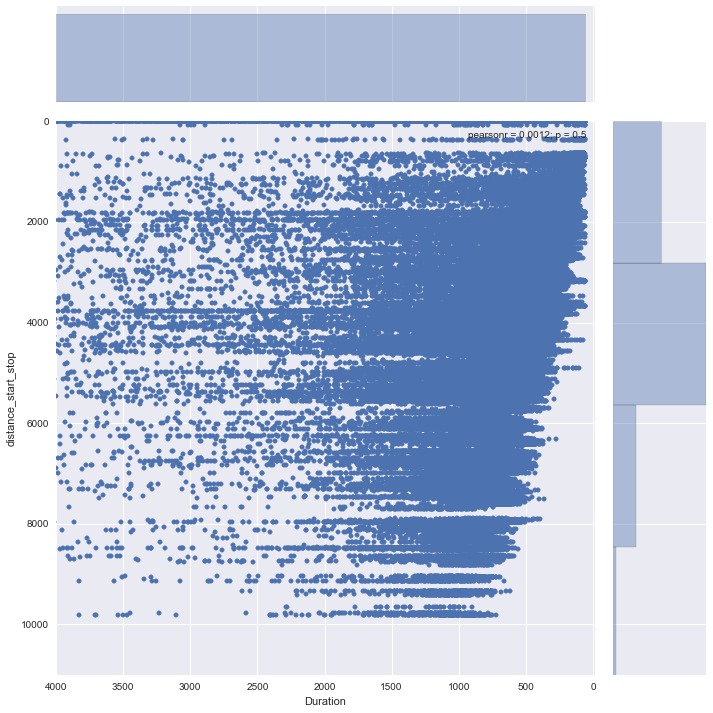

In [25]:
sns.jointplot(trip_data_sf['Duration'], trip_data_sf['distance_start_stop'], kind='scatter', size=10, xlim={-10, 4000}, ylim={-10,11000})

###Setting up my bicycle trip features for K-Means

In [26]:
features = trip_data_sf[['Duration', 'distance_start_stop']].copy()
features['day_of_week'] = pd.DatetimeIndex(trip_data_sf['Start Date']).dayofweek
features['hours'] = pd.DatetimeIndex(trip_data_sf['Start Date']).hour

In [27]:
features.head()

,Duration,distance_start_stop,day_of_week,hours
0,765,5451.037117,0,23
1,886,5451.037117,0,18
2,725,5451.037117,0,17
3,1034,5451.037117,0,17
4,871,5451.037117,0,16


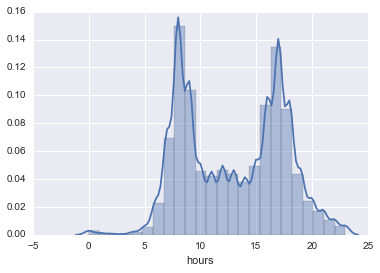

In [28]:
sns.distplot(features['hours'], bins=24, hist=True)

(array([ 57820.,  60517.,  59414.,  57324.,  52616.,  18752.,  14662.]),
 array([ 0.        ,  0.85714286,  1.71428571,  2.57142857,  3.42857143,
         4.28571429,  5.14285714,  6.        ]),
 <a list of 7 Patch objects>)

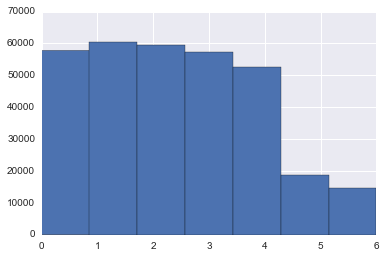

In [30]:
plt.hist(features['day_of_week'], bins=7)

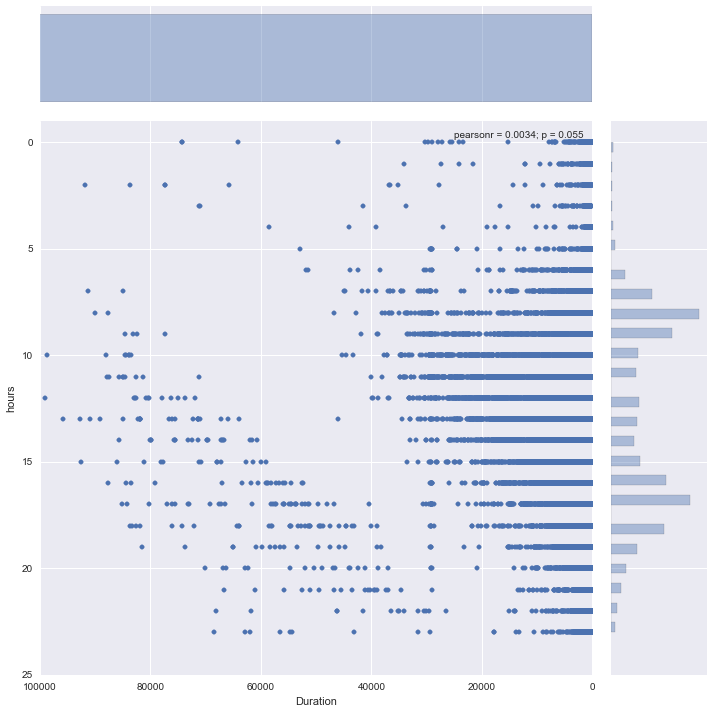

In [31]:
sns.jointplot(features.Duration, features.hours, kind='scatter', size=10, xlim={-1, 100000}, ylim={-1,25})

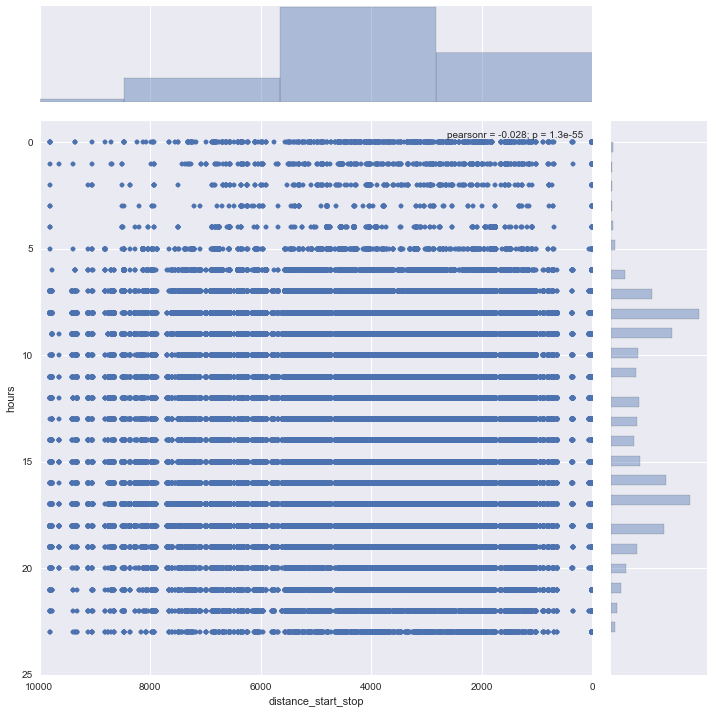

In [32]:
sns.jointplot(features.distance_start_stop, features.hours, kind='scatter', size=10, xlim={-1, 10000}, ylim={-1,25})

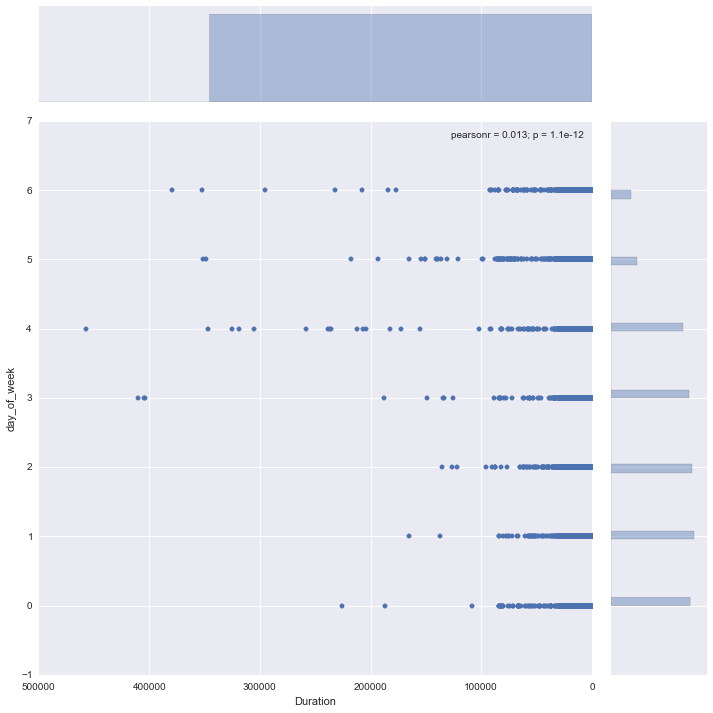

In [33]:
sns.jointplot(features.Duration, features.day_of_week, kind='scatter', size=10, xlim={-1, 500000}, ylim={-1,7})

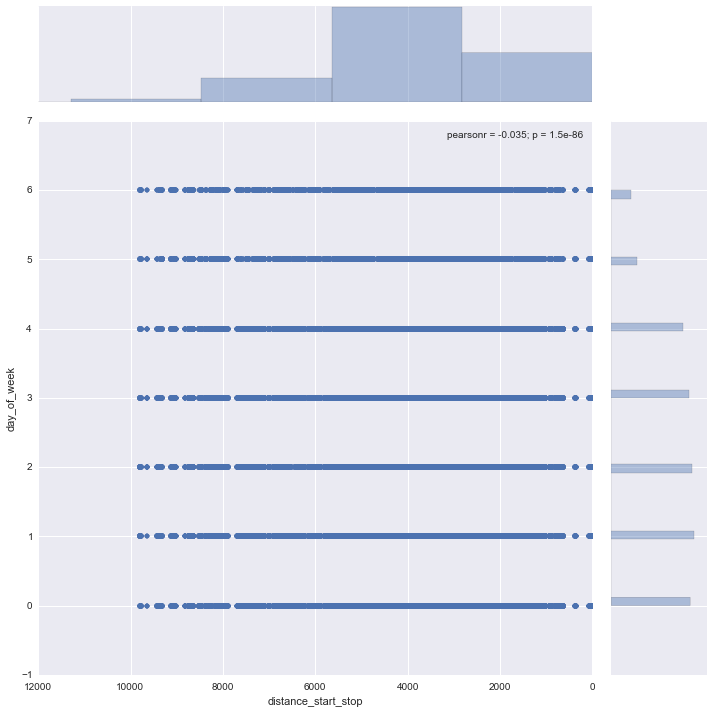

In [34]:
sns.jointplot(features.distance_start_stop, features.day_of_week, kind='scatter', size=10, xlim={-1, 12000}, ylim={-1,7})

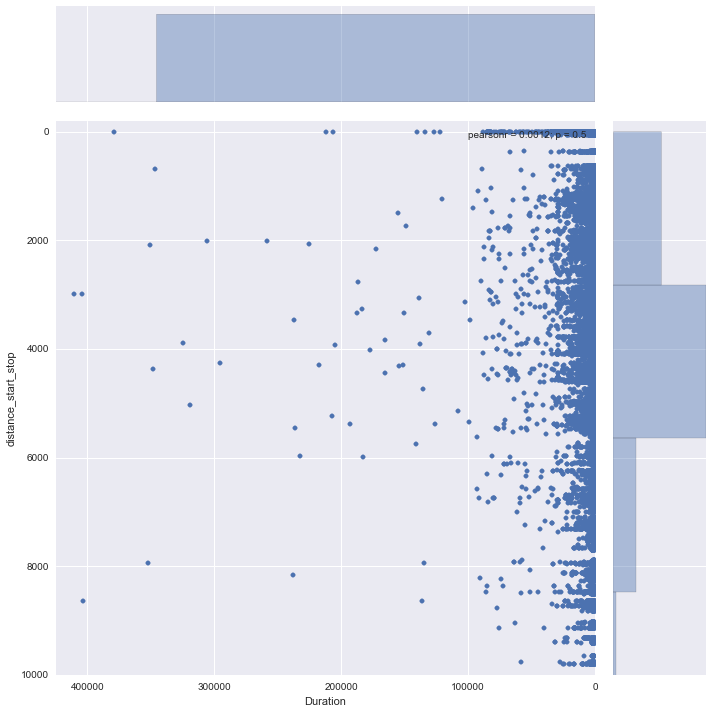

In [35]:
sns.jointplot(features.Duration, features.distance_start_stop, kind='scatter', size=10, xlim={-1, 425000}, ylim={-200,10000})

###Normalizing the data and clustering

In [36]:
cols_to_norm = ['Duration','distance_start_stop', 'day_of_week', 'hours'] 
features[cols_to_norm] = features[cols_to_norm].apply(lambda x: (x - x.mean()) / (x.max() - x.min()))

In [38]:
cluster_num = 11
model = km(n_clusters = cluster_num, n_init=5, max_iter=20)
model.fit_transform(features)
features.head()

,Duration,distance_start_stop,day_of_week,hours
0,-0.000012,0.010929,-0.385914,0.435232
1,-0.000005,0.010929,-0.385914,0.217841
2,-0.000015,0.010929,-0.385914,0.174362
3,0.000003,0.010929,-0.385914,0.174362
4,-0.000006,0.010929,-0.385914,0.130884


In [39]:
features['labels'] = model.labels_
features.head()

,Duration,distance_start_stop,day_of_week,hours,labels
0,-0.000012,0.010929,-0.385914,0.435232,4
1,-0.000005,0.010929,-0.385914,0.217841,4
2,-0.000015,0.010929,-0.385914,0.174362,4
3,0.000003,0.010929,-0.385914,0.174362,4
4,-0.000006,0.010929,-0.385914,0.130884,4


In [41]:
#sampling my data to run the silhouette score
sample = features.sample(4000)

In [42]:
silhouette_score(sample.values, sample['labels'].values)

0.89998863959835007

In [32]:
#finding the cluster centers
model.cluster_centers_[0]

array([ -1.41234762e-05,   3.13328110e-04,   1.14086254e-01,
        -1.91600857e-01])

###Visualizing the cluster centers to double check accuracy of model

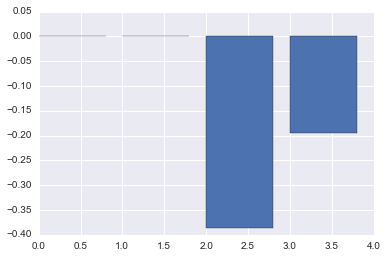

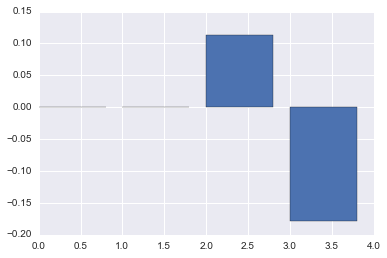

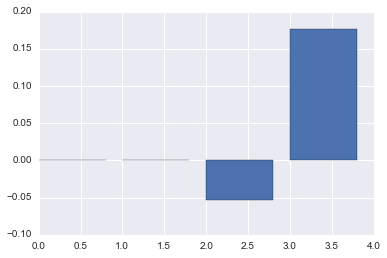

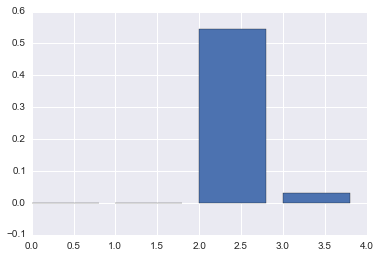

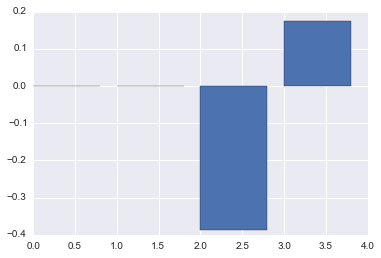

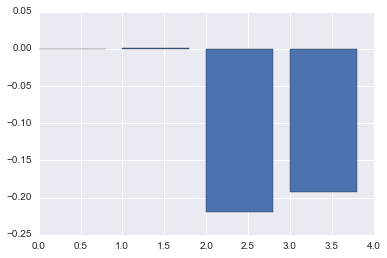

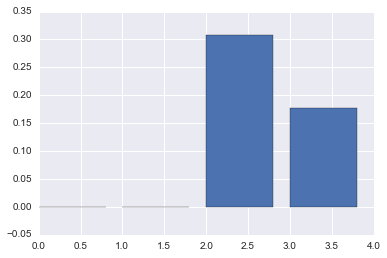

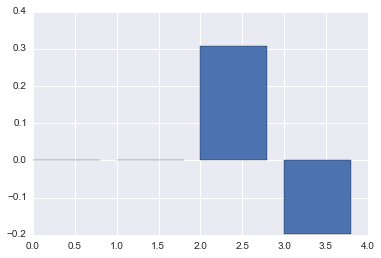

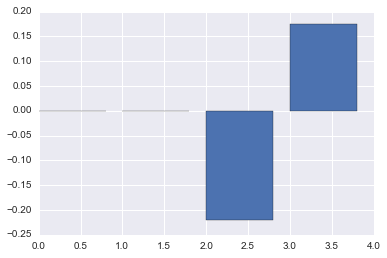

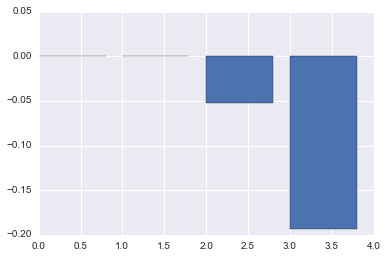

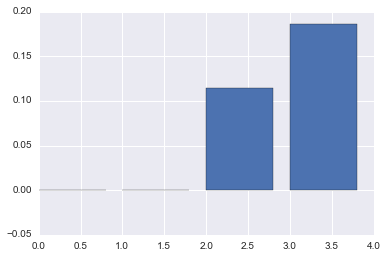

In [43]:
#bars are features - duration, distance, day of the week, and time of the day
for i in range(11):
    plt.bar([0,1,2,3], model.cluster_centers_[i])
    plt.show()

In [44]:
trips_grouped = trip_data_sf.groupby(['Start Station', 'End Station'])['Start Station'].count()

In [45]:
trips_grouped

Start Station                                  End Station                                  
2nd at Folsom                                  2nd at Folsom                                      87
                                               2nd at South Park                                 299
                                               2nd at Townsend                                   446
                                               5th at Howard                                     116
                                               Beale at Market                                   127
                                               Broadway St at Battery St                          69
                                               Civic Center BART (7th at Market)                  49
                                               Clay at Battery                                   243
                                               Commercial at Montgomery                          13

In [ ]:
goog = [trip_data_sf, features]
goog_sample = pd.concat(goog)

trip_data_sf['labels'] = features['labels'].copy()
gis_samp = trip_data_sf.sample(10000)
gis_samp.to_csv("gis_samp.csv")